In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import warnings
import json
warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path.cwd().parent.parent.parent
DATA_DIR = BASE_DIR / "ppi-assembly" / "processed_data"

# Add hcat package to path
sys.path.insert(0, str(BASE_DIR / "cat-hcat" / "hcat"))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Load tree and metadata
tree_path = DATA_DIR / "clustering" / "hierarchical" / "brca_ppi_paris.json"
metadata_path = DATA_DIR / "metadata" / "node_to_sequence.json"

with open(tree_path, 'r') as f:
    tree_data = json.load(f)

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"Tree data loaded: {tree_data['num_nodes']} nodes")
print(f"Metadata loaded: {len(metadata)} entries")

Tree data loaded: 2394 nodes
Metadata loaded: 2394 entries


In [3]:
import pandas as pd
import json

# Load your metadata JSON
with open(metadata_path, 'r') as f:
    metadata_dict = json.load(f)

# Convert to DataFrame with SPACE-SEPARATED sequences for ProteinBERT
metadata_df = pd.DataFrame([
    {
        'id': int(node_id),
        'title': '',  # Empty title
        'abstract': ' '.join(list(sequence))  # SPACE-SEPARATE the amino acids!
    }
    for node_id, sequence in metadata_dict.items()
])

# Save to CSV
metadata_df.to_csv('metadata.csv', index=False)

metadata_df.head()

,id,title,abstract
0,0,,M G L T V S A L F S R I F G K K Q M R I L M V ...
1,1,,M T A E E M K A T E S G A Q S A P L P M E G V ...
2,2,,M T A E L Q Q D D A A G A A D G H G S S C Q M ...
3,3,,M A A N K P K G Q N S L A L H K V I M V G S G ...
4,4,,M N R G V P F R H L L L V L Q L A L L P A A T ...


In [4]:
# IMPORTANT: Create test split BEFORE training
# This ensures validation and test sets use the same nodes
from notebook_utils import create_test_split

all_node_ids = [str(node_id) for node_id in metadata_df['id'].values]
test_val_nodes = create_test_split(all_node_ids, test_ratio=0.1, seed=42)

print(f"\nTest/Val set: {len(test_val_nodes)} nodes ({len(test_val_nodes)/len(all_node_ids)*100:.1f}%)")
print(f"Train set: {len(all_node_ids) - len(test_val_nodes)} nodes")

metadata_df.head()


Test/Val set: 239 nodes (10.0%)
Train set: 2155 nodes


,id,title,abstract
0,0,,M G L T V S A L F S R I F G K K Q M R I L M V ...
1,1,,M T A E E M K A T E S G A Q S A P L P M E G V ...
2,2,,M T A E L Q Q D D A A G A A D G H G S S C Q M ...
3,3,,M A A N K P K G Q N S L A L H K V I M V G S G ...
4,4,,M N R G V P F R H L L L V L Q L A L L P A A T ...


In [5]:
from train import train_model

# Train model with adaptive margin triplet loss using ProteinBERT
finetuned_model, tokenizer, history = train_model(
    tree_json_path=str(tree_path),
    metadata_csv_path='metadata.csv',
    output_dir=str(BASE_DIR / "cat-hcat" / "models" / "finetuned_proteinbert_adaptive_margin"),
    model_name='facebook/esm2_t12_35M_UR50D',
    device=str(device),
    batch_size=16,
    epochs=3,
    lr=2e-5,
    base_margin=0.5,        # Base triplet margin
    distance_scale=0.005,     # KEY: Scale margin by tree distance
    samples_per_leaf=3,     # ~43K triplets for 14K leaves
    pooling='cls',
    sampling_strategy='hierarchical',
    val_nodes=test_val_nodes,  # Use same nodes for validation as we'll use for testing
    loss_type='hybrid',
    triplet_weight=0.8,        # Weight for ranking component
    regression_weight=0.2,     # Weight for distance regression
)

Using device: cuda

Loading tree from /home/vikramr2/ppi-assembly/processed_data/clustering/hierarchical/brca_ppi_paris.json...
  Leaves: 2394
  Total nodes: 4787
  Max depth: 40

Loading metadata from metadata.csv...
  Entries: 2394

Loading model: facebook/esm2_t12_35M_UR50D...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating dataset...


Generating triplets: 100%|██████████| 2394/2394 [00:27<00:00, 87.15it/s]


  Generated 7182 triplets
  Using 239 nodes for validation (node-level split)
  Train: 6465 triplets | Val: 717 triplets
  Train nodes: 0 (approx)
  Val nodes: 239

Configuring loss function...
  Auto-detected max_tree_distance: 40.0
Loss: HybridHierarchicalLoss
  Base margin: 0.5
  Distance scale: 0.005
  Max tree distance: 40.0
  Triplet weight: 0.8
  Regression weight: 0.2

Starting training for 3 epochs

Epoch 1/3
------------------------------------------------------------


Training: 100%|██████████| 405/405 [04:00<00:00,  1.68it/s, loss=0.0008]


  Train loss: 0.0149


Evaluating: 100%|██████████| 45/45 [00:11<00:00,  4.00it/s]


  Val loss: 0.0054
  ✓ New best! Saving to /home/vikramr2/cat-hcat/models/finetuned_proteinbert_adaptive_margin...

Epoch 2/3
------------------------------------------------------------


Training: 100%|██████████| 405/405 [04:00<00:00,  1.68it/s, loss=0.0021]


  Train loss: 0.0035


Evaluating: 100%|██████████| 45/45 [00:11<00:00,  3.98it/s]


  Val loss: 0.0051
  ✓ New best! Saving to /home/vikramr2/cat-hcat/models/finetuned_proteinbert_adaptive_margin...

Epoch 3/3
------------------------------------------------------------


Training: 100%|██████████| 405/405 [04:00<00:00,  1.69it/s, loss=0.0003]


  Train loss: 0.0014


Evaluating: 100%|██████████| 45/45 [00:11<00:00,  3.99it/s]


  Val loss: 0.0022
  ✓ New best! Saving to /home/vikramr2/cat-hcat/models/finetuned_proteinbert_adaptive_margin...

Training complete!
  Best val loss: 0.0022
  Model saved to: /home/vikramr2/cat-hcat/models/finetuned_proteinbert_adaptive_margin


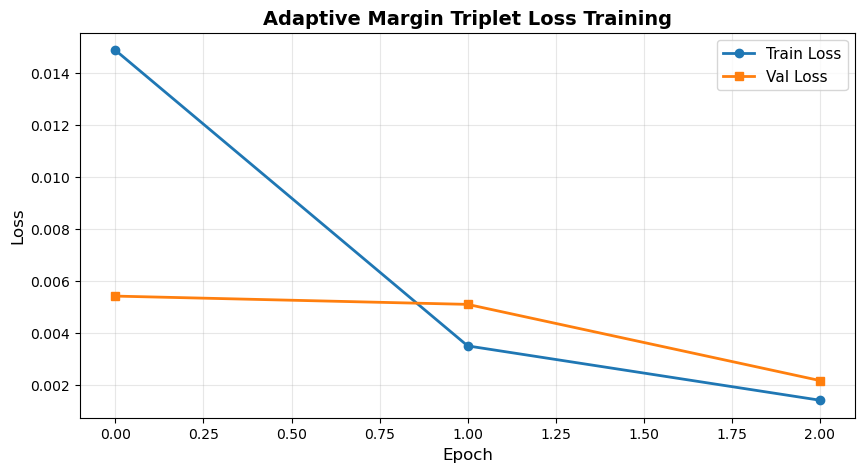


Final train loss: 0.0014
Final val loss: 0.0022


In [6]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], marker='o', label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], marker='s', label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Adaptive Margin Triplet Loss Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")

In [7]:
from notebook_utils import compute_embeddings

# Load the BEST saved model (not the final epoch model)
output_dir = BASE_DIR / "cat-hcat" / "models" / "finetuned_proteinbert_adaptive_margin"

print("Loading best saved model...")
best_tokenizer = AutoTokenizer.from_pretrained(str(output_dir))
best_model = AutoModel.from_pretrained(str(output_dir)).to(device)
best_model.eval()

print(f"✓ Loaded best model from: {output_dir}")

# Compute embeddings for all nodes using BEST model
print("\nComputing embeddings with best model...")
embeddings_dict = compute_embeddings(
    best_model,  # Use BEST saved model
    best_tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Computed embeddings for {len(embeddings_dict)} nodes")

Loading best saved model...
✓ Loaded best model from: /home/vikramr2/cat-hcat/models/finetuned_proteinbert_adaptive_margin

Computing embeddings with best model...
Preparing 2394 documents...


Preparing:   0%|          | 0/2394 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/75 [00:00<?, ?it/s]

✓ Computed embeddings for 2394 nodes
✓ Computed embeddings for 2394 nodes



NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/ppi-assembly/processed_data/network/brca_ppi_edgelist_cleaned.csv
Loaded 53363 edges
Network has 2394 unique nodes
Test nodes with embeddings and edges: 239

Evaluating link prediction with top-k retrieval...
Test nodes: 239
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/239 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 239
Negative samples per positive: 10


Sampling edges:   0%|          | 0/239 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.2167
    Precision Normalized@5: 0.2185
    Recall@5: 0.0326
    Hit Rate@5: 0.5188
  K=10:
    Precision@10: 0.1615
    Precision Normalized@10: 0.1663
    Recall@10: 0.0423
    Hit Rate@10: 0.5732
  K=20:
    Precision@20: 0.1211
    Precision Normalized@20: 0.1337
    Recall@20: 0.0572
    Hit Rate@20: 0.6569
  K=50:
    Precision@50: 0.0877
    Precision Normalized@50: 0.1259
    Recall@50: 0.0936
    Hit Rate@50: 0.7490
  K=100:
    Precision@100: 0.0671
    Precision Normalized@100: 0.1455
    Recall@100: 0.1376
    Hit Rate@100: 0.8368

AUC Metrics:
  AUC-ROC: 0.5893
  AUC-PR: 0.1716



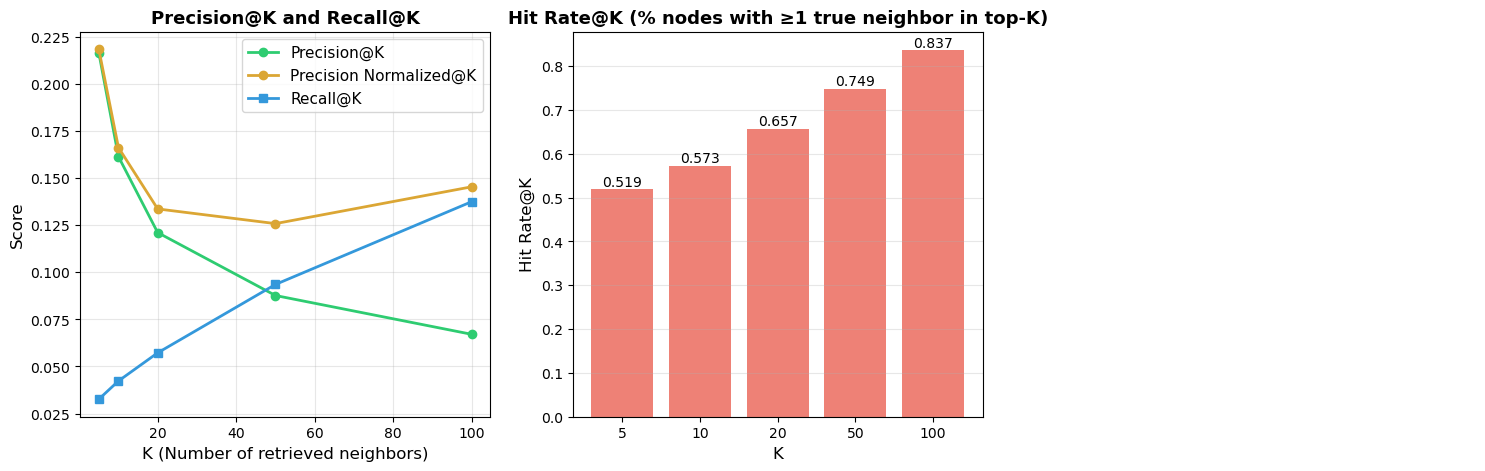

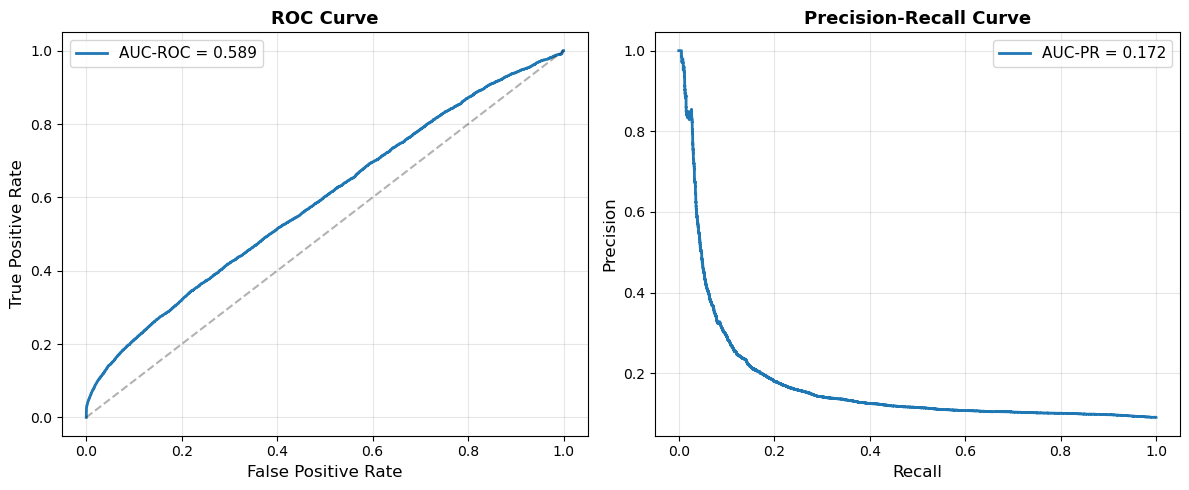

<Figure size 640x480 with 0 Axes>

In [8]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat-hcat" / "utils" / "evaluation"))

from link_prediction import (
    evaluate_network_link_prediction,
    plot_link_prediction_results
)

edgelist_path = DATA_DIR / "network" / "brca_ppi_edgelist_cleaned.csv"

# Evaluate fine-tuned model
results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

# Visualize
plot_link_prediction_results(results['topk'], results['auc'])

In [9]:
# Load baseline SciBERT (not fine-tuned)
print("Loading baseline model...")
baseline_model = AutoModel.from_pretrained('facebook/esm2_t12_35M_UR50D').to(device)
tokenizer = AutoTokenizer.from_pretrained('facebook/esm2_t12_35M_UR50D')

# Compute baseline embeddings
print("Computing baseline embeddings...")
baseline_embeddings = compute_embeddings(
    baseline_model,
    tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Baseline embeddings: {len(baseline_embeddings)} nodes")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading baseline model...
Computing baseline embeddings...
Preparing 2394 documents...


Preparing:   0%|          | 0/2394 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/75 [00:00<?, ?it/s]

✓ Computed embeddings for 2394 nodes
✓ Baseline embeddings: 2394 nodes


Evaluating baseline...

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/ppi-assembly/processed_data/network/brca_ppi_edgelist_cleaned.csv
Loaded 53363 edges
Network has 2394 unique nodes
Test nodes with embeddings and edges: 239

Evaluating link prediction with top-k retrieval...
Test nodes: 239
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/239 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 239
Negative samples per positive: 10


Sampling edges:   0%|          | 0/239 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.2184
    Precision Normalized@5: 0.2208
    Recall@5: 0.0340
    Hit Rate@5: 0.4895
  K=10:
    Precision@10: 0.1661
    Precision Normalized@10: 0.1719
    Recall@10: 0.0427
    Hit Rate@10: 0.5523
  K=20:
    Precision@20: 0.1295
    Precision Normalized@20: 0.1420
    Recall@20: 0.0591
    Hit Rate@20: 0.6234
  K=50:
    Precision@50: 0.0940
    Precision Normalized@50: 0.1334
    Recall@50: 0.0997
    Hit Rate@50: 0.7573
  K=100:
    Precision@100: 0.0722
    Precision Normalized@100: 0.1509
    Recall@100: 0.1425
    Hit Rate@100: 0.8159

AUC Metrics:
  AUC-ROC: 0.6172
  AUC-PR: 0.1946



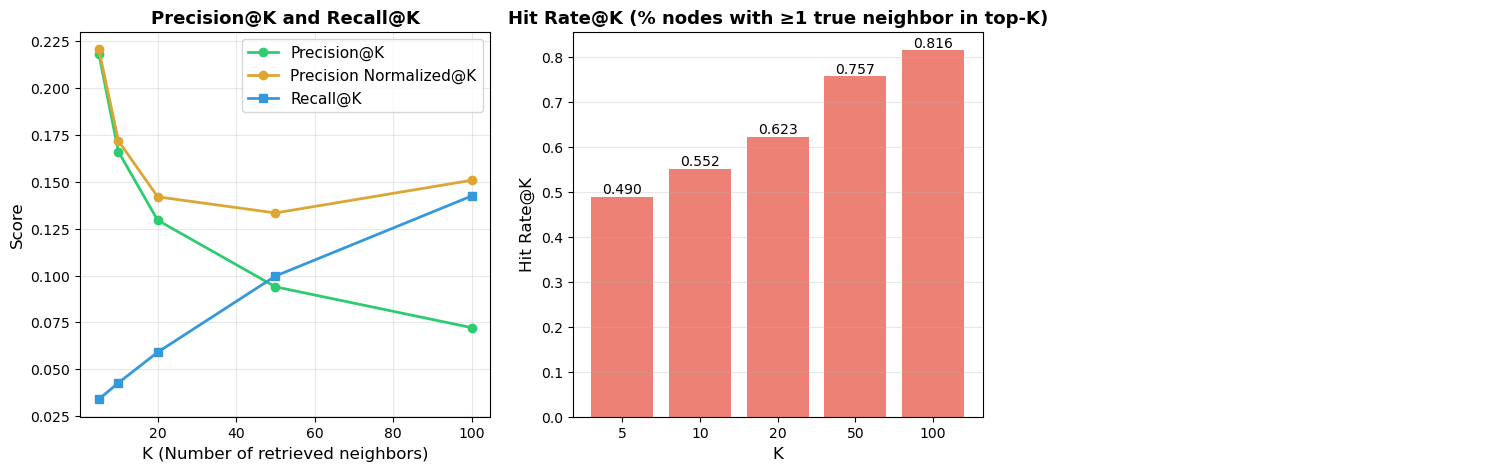

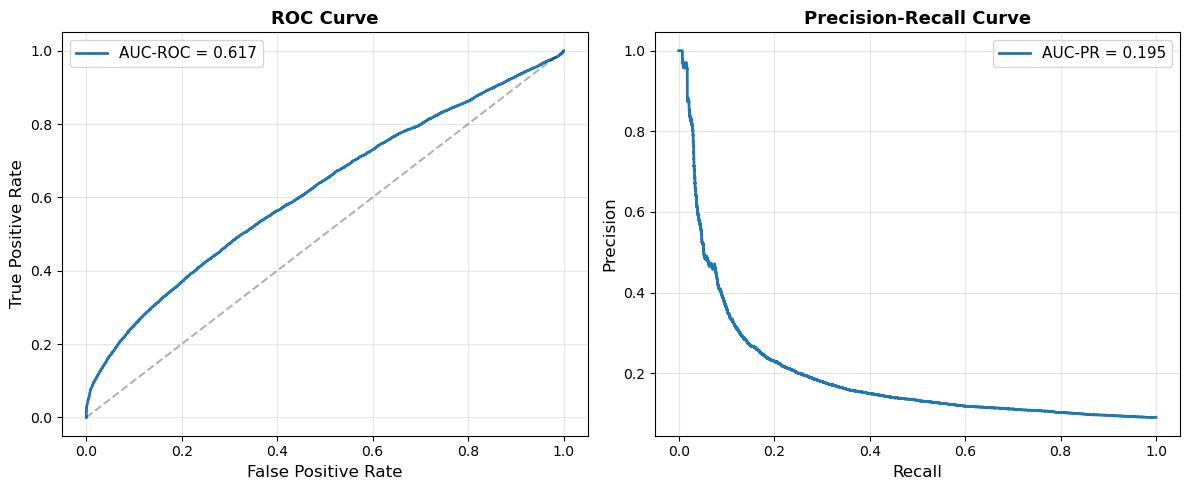

<Figure size 640x480 with 0 Axes>

In [10]:
# Evaluate baseline
print("Evaluating baseline...")
baseline_results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=baseline_embeddings,
    test_nodes=test_val_nodes,
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

# Visualize
plot_link_prediction_results(baseline_results['topk'], baseline_results['auc'])

In [11]:
# Create comparison table
k_values = [5, 10, 20, 50, 100]
comparison_data = []

for k in k_values:
    baseline_prec = baseline_results['topk']['summary'][k]['precision@k']
    finetuned_prec = results['topk']['summary'][k]['precision@k']

    comparison_data.append({
        'K': k,
        'Baseline Precision': baseline_prec,
        'Fine-tuned Precision': finetuned_prec,
        'Improvement': finetuned_prec - baseline_prec,
        'Improvement %': ((finetuned_prec - baseline_prec) / baseline_prec) * 100
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("PRECISION@K COMPARISON: Baseline vs Fine-tuned (Adaptive Margin Loss)")
print("="*80)
print(comparison_df.to_string(index=False))

# AUC comparison
print("\n" + "="*80)
print("AUC METRICS")
print("="*80)
print(f"Baseline AUC-ROC:    {baseline_results['auc']['auc_roc']:.4f}")
print(f"Fine-tuned AUC-ROC:  {results['auc']['auc_roc']:.4f}")
print(f"Improvement:         {results['auc']['auc_roc'] - baseline_results['auc']['auc_roc']:.4f} " +
      f"({((results['auc']['auc_roc'] - baseline_results['auc']['auc_roc'])/baseline_results['auc']['auc_roc'])*100:.1f}%)")
print()
print(f"Baseline AUC-PR:     {baseline_results['auc']['auc_pr']:.4f}")
print(f"Fine-tuned AUC-PR:   {results['auc']['auc_pr']:.4f}")
print(f"Improvement:         {results['auc']['auc_pr'] - baseline_results['auc']['auc_pr']:.4f} " +
      f"({((results['auc']['auc_pr'] - baseline_results['auc']['auc_pr'])/baseline_results['auc']['auc_pr'])*100:.1f}%)")


PRECISION@K COMPARISON: Baseline vs Fine-tuned (Adaptive Margin Loss)
  K  Baseline Precision  Fine-tuned Precision  Improvement  Improvement %
  5            0.218410              0.216736    -0.001674      -0.766284
 10            0.166109              0.161506    -0.004603      -2.770781
 20            0.129498              0.121130    -0.008368      -6.462036
 50            0.093975              0.087699    -0.006276      -6.678540
100            0.072176              0.067071    -0.005105      -7.072464

AUC METRICS
Baseline AUC-ROC:    0.6172
Fine-tuned AUC-ROC:  0.5893
Improvement:         -0.0279 (-4.5%)

Baseline AUC-PR:     0.1946
Fine-tuned AUC-PR:   0.1716
Improvement:         -0.0230 (-11.8%)


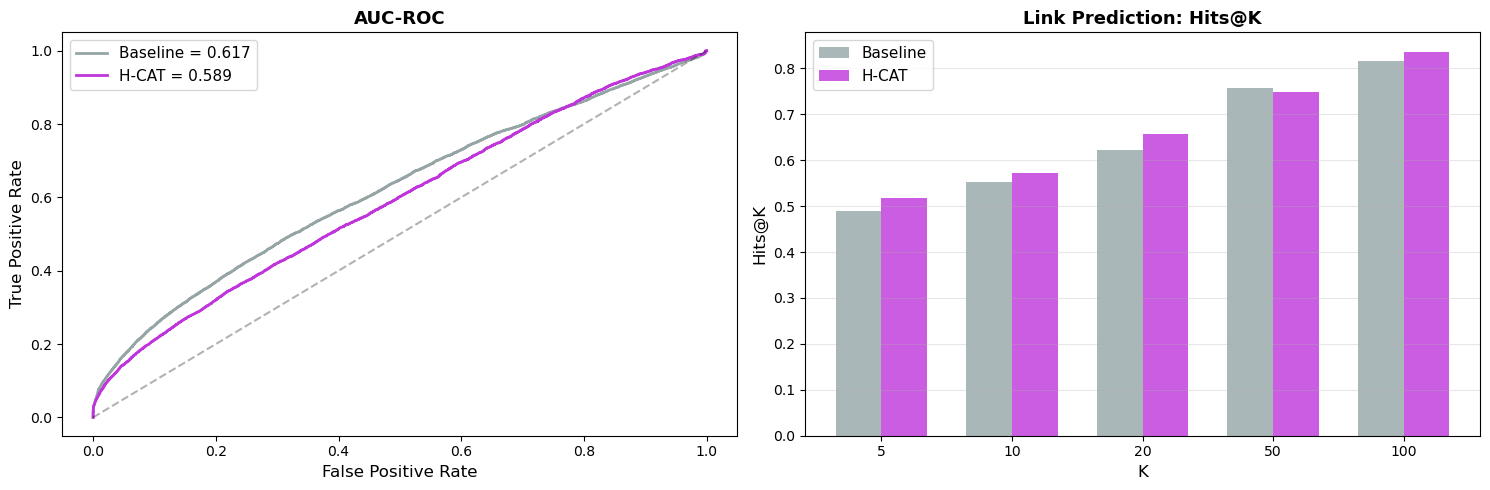

In [12]:
from sklearn.metrics import roc_curve

# Side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# AUC-ROC
ax = axes[0]

fpr, tpr, _ = roc_curve(results['auc']['y_true'], results['auc']['y_scores'])
baseline_fpr, baseline_tpr, _ = roc_curve(results['auc']['y_true'], baseline_results['auc']['y_scores'])

ax.plot(baseline_fpr, baseline_tpr, linewidth=2, label=f"Baseline = {baseline_results['auc']['auc_roc']:.3f}", color='#95a5a6')
ax.plot(fpr, tpr, linewidth=2, label=f"H-CAT = {results['auc']['auc_roc']:.3f}", color='#bf34db')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('AUC-ROC', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)

# Hit Rate @ K
ax = axes[1]
x = np.arange(len(k_values))
width = 0.35

baseline_prec = [baseline_results['topk']['summary'][k]['hit_rate@k'] for k in k_values]
finetuned_prec = [results['topk']['summary'][k]['hit_rate@k'] for k in k_values]

bars1 = ax.bar(x - width/2, baseline_prec, width, label='Baseline', alpha=0.8, color='#95a5a6')
bars2 = ax.bar(x + width/2, finetuned_prec, width, label='H-CAT', alpha=0.8, color='#bf34db')

ax.set_xlabel('K', fontsize=12)
ax.set_ylabel('Hits@K', fontsize=12)
ax.set_title('Link Prediction: Hits@K', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(k_values)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Save comparison
results_dir = BASE_DIR / "cat-hcat" / "hcat" / "experiments" / "results"
results_dir.mkdir(exist_ok=True, parents=True)


In [14]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat-hcat"))

from hcat.tree_utils import HierarchicalTree
from utils.evaluation.tree_eval import evaluate_tree_structure

# Load your tree
tree = HierarchicalTree(tree_data)

In [15]:
# Evaluate baseline embeddings with your test set
baseline_tree_results = evaluate_tree_structure(
    tree=tree,
    embeddings_dict=baseline_embeddings,
    test_nodes=test_val_nodes,  # Your test set!
    depth_levels=[2, 3, 4, 5],
    distance_sample_size=2000,
    random_state=42
)


               TREE STRUCTURE EVALUATION

SUBTREE CLASSIFICATION EVALUATION
Evaluating at depths: [2, 3, 4, 5]
Cross-validation folds: 5
Evaluating 239 test nodes

--- Depth 2 ---
  Subtrees: 4
  Samples: 239
  Accuracy: 0.5941 ± 0.0094
  Random baseline: 0.4507
  Lift over random: 1.32x

--- Depth 3 ---
  Subtrees: 8
  Samples: 239
  Accuracy: 0.3807 ± 0.0323
  Random baseline: 0.2343
  Lift over random: 1.62x

--- Depth 4 ---
  Skipping: smallest class has only 1 sample(s)

--- Depth 5 ---
  Skipping: smallest class has only 1 sample(s)

TREE DISTANCE CORRELATION EVALUATION
Evaluating 239 test nodes
Sampling 2000 pairs...


Computing distances:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: -0.0137 (p=5.41e-01)
Number of pairs evaluated: 2000

Mean embedding distance by tree distance:
  Tree dist 7: 0.0431 ± 0.0186 (15 pairs)
  Tree dist 8: 0.0431 ± 0.0175 (27 pairs)
  Tree dist 9: 0.0462 ± 0.0150 (44 pairs)
  Tree dist 10: 0.0460 ± 0.0144 (62 pairs)
  Tree dist 11: 0.0441 ± 0.0149 (111 pairs)

SUMMARY

Subtree Classification:
  Depth 2: 0.5941 (baseline: 0.4507, 4 classes)
  Depth 3: 0.3807 (baseline: 0.2343, 8 classes)

Tree Distance Correlation:
  Spearman ρ: -0.0137



In [16]:
finetuned_tree_results = evaluate_tree_structure(
    tree=tree,
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,  # Same test set
    depth_levels=[2, 3, 4, 5],
    distance_sample_size=2000,
    random_state=42
)


               TREE STRUCTURE EVALUATION

SUBTREE CLASSIFICATION EVALUATION
Evaluating at depths: [2, 3, 4, 5]
Cross-validation folds: 5
Evaluating 239 test nodes

--- Depth 2 ---
  Subtrees: 4
  Samples: 239
  Accuracy: 0.5941 ± 0.0094
  Random baseline: 0.4507
  Lift over random: 1.32x

--- Depth 3 ---
  Subtrees: 8
  Samples: 239
  Accuracy: 0.3431 ± 0.0094
  Random baseline: 0.2343
  Lift over random: 1.46x

--- Depth 4 ---
  Skipping: smallest class has only 1 sample(s)

--- Depth 5 ---
  Skipping: smallest class has only 1 sample(s)

TREE DISTANCE CORRELATION EVALUATION
Evaluating 239 test nodes
Sampling 2000 pairs...


Computing distances:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.2204 (p=1.97e-23)
Number of pairs evaluated: 2000

Mean embedding distance by tree distance:
  Tree dist 7: 0.0394 ± 0.0696 (15 pairs)
  Tree dist 8: 0.0266 ± 0.0385 (27 pairs)
  Tree dist 9: 0.0471 ± 0.1025 (44 pairs)
  Tree dist 10: 0.0231 ± 0.0196 (62 pairs)
  Tree dist 11: 0.0283 ± 0.0275 (111 pairs)

SUMMARY

Subtree Classification:
  Depth 2: 0.5941 (baseline: 0.4507, 4 classes)
  Depth 3: 0.3431 (baseline: 0.2343, 8 classes)

Tree Distance Correlation:
  Spearman ρ: 0.2204



In [17]:
content_dict = (
    metadata_df.apply(
        lambda row: f"{row['title']} {row['abstract']}".strip() 
        if pd.notna(row['title']) or pd.notna(row['abstract']) 
        else '',
        axis=1
    )
    .to_dict()
)

content_dict = {str(k): v for k, v in content_dict.items()}

In [18]:
# First, check what columns you have:
print(metadata_df.columns)

# Then create text_dict using the correct ID column
# Replace 'paper_id' or 'id' with your actual column name
text_dict = {}
for _, row in metadata_df.iterrows():
    node_id = str(row['id'])  # or row['id'], row['node_id'], etc.
    title = str(row['title']) if pd.notna(row['title']) else ''
    abstract = str(row['abstract']) if pd.notna(row['abstract']) else ''
    
    combined_text = f"{title} {abstract}".strip()
    if combined_text:
        text_dict[node_id] = combined_text

print(f"Created text dictionary with {len(text_dict)} entries")

# Verify overlap
overlap = set(embeddings_dict.keys()) & set(text_dict.keys())
print(f"Overlap: {len(overlap)} keys in common")

Index(['id', 'title', 'abstract'], dtype='object')
Created text dictionary with 2394 entries
Overlap: 2394 keys in common



GRAPH DISTANCE CORRELATION EVALUATION

Loading edgelist from: /home/vikramr2/ppi-assembly/processed_data/network/brca_ppi_edgelist_cleaned.csv
Loaded 53363 edges
Building NetworkKit graph...
Graph has 2394 nodes and 53363 edges
Test nodes with embeddings and in graph: 239

Sampling node pairs (strategy: stratified)...
Sampling from 239 test nodes...


Stratified sampling:   0%|          | 0/239 [00:00<?, ?it/s]

Sampled 20726 pairs

Computing shortest path distances...


Computing shortest paths:   0%|          | 0/239 [00:00<?, ?it/s]

Pairs with finite graph distance: 20726

Computing embedding distances (metric: cosine)...

Final pair count: 20726

Computing correlations...

RESULTS SUMMARY

Correlation Metrics:
  Spearman correlation: 0.1606 (p=8.7605e-120)
  Pearson correlation: 0.1315 (p=1.2308e-80)

Distance Distribution:
  Distance 1: 4852 pairs, mean emb dist = 0.0383 ± 0.0826
  Distance 2: 6229 pairs, mean emb dist = 0.0435 ± 0.0900
  Distance 3: 6229 pairs, mean emb dist = 0.0496 ± 0.1061
  Distance 4: 3394 pairs, mean emb dist = 0.1145 ± 0.3249
  Distance 5: 22 pairs, mean emb dist = 0.0193 ± 0.0080



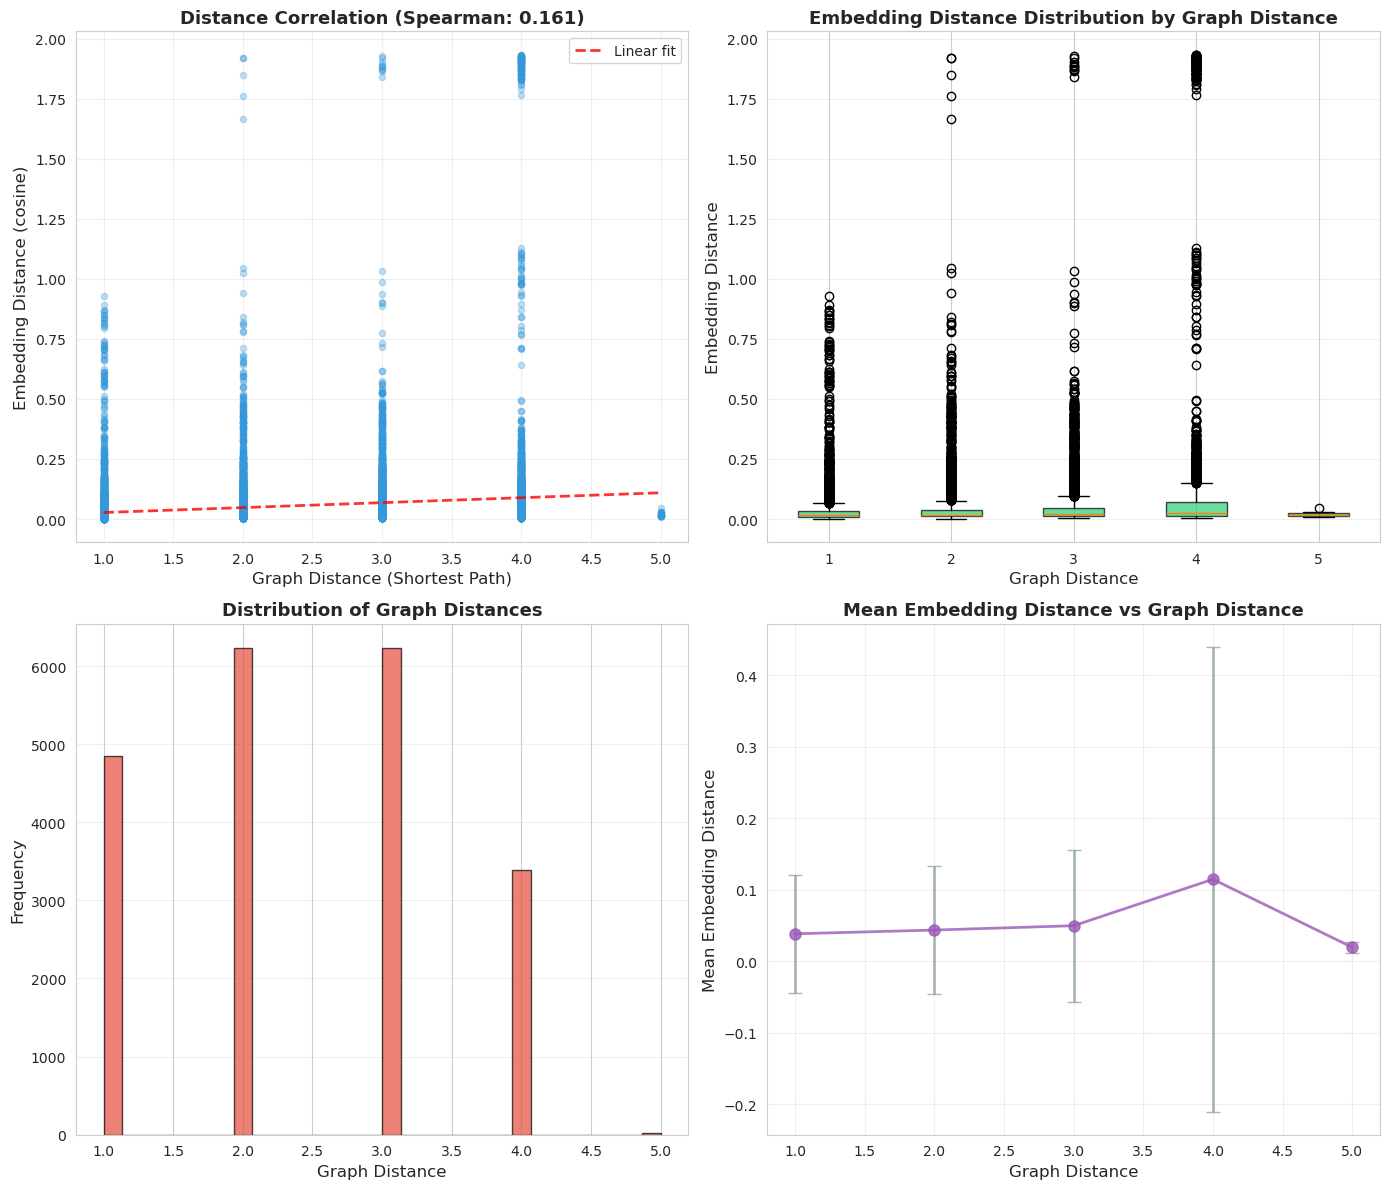

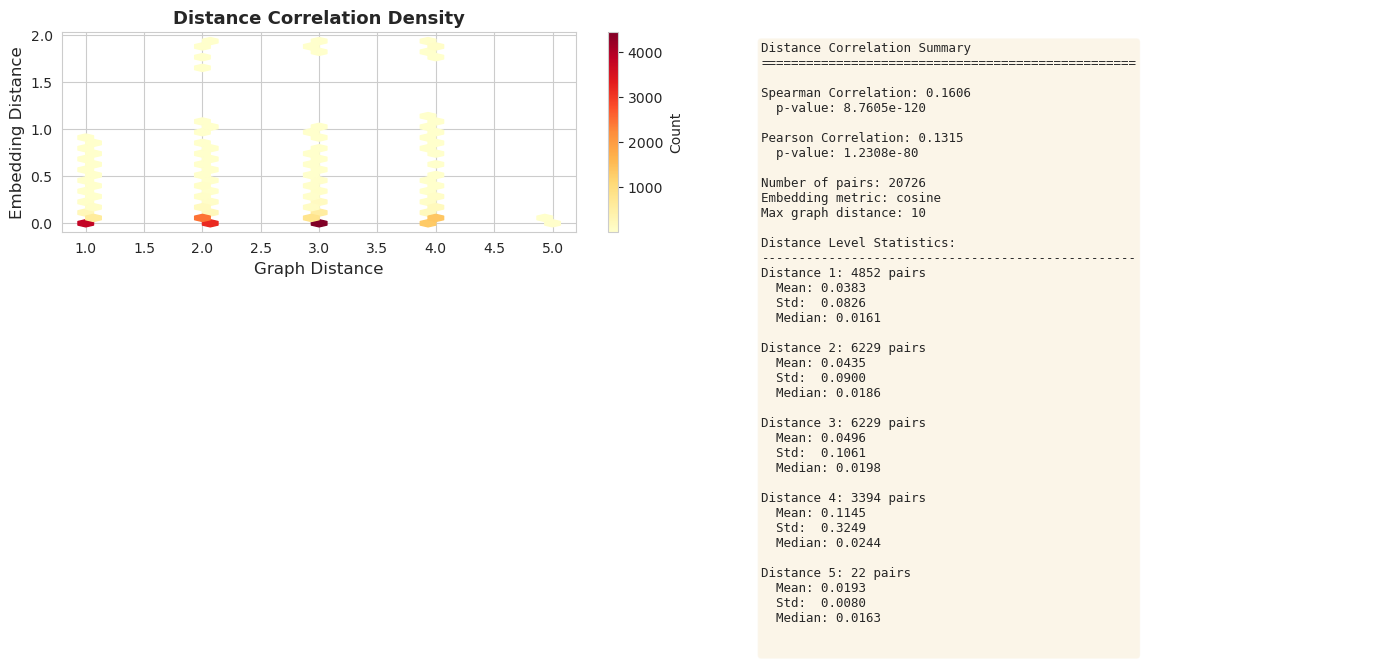

In [19]:
from utils.evaluation.graph_dist_eval import evaluate_distance_correlation, plot_distance_correlation

output_dir = BASE_DIR / "cat-hcat" / "models" / "finetuned_proteinbert_adaptive_margin"

# Just like link_prediction.py
finetuned_distance_evaluation = evaluate_distance_correlation(
    edgelist_path=edgelist_path,
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,  # List of node IDs to evaluate
    num_samples_per_node=100,     # Sample 100 pairs per test node
    max_graph_distance=10,
    embedding_distance_metric='cosine',
    sampling_strategy='stratified'  # or 'random'
)

plot_distance_correlation(finetuned_distance_evaluation)


GRAPH DISTANCE CORRELATION EVALUATION

Loading edgelist from: /home/vikramr2/ppi-assembly/processed_data/network/brca_ppi_edgelist_cleaned.csv
Loaded 53363 edges
Building NetworkKit graph...
Graph has 2394 nodes and 53363 edges
Test nodes with embeddings and in graph: 239

Sampling node pairs (strategy: stratified)...
Sampling from 239 test nodes...


Stratified sampling:   0%|          | 0/239 [00:00<?, ?it/s]

Sampled 20726 pairs

Computing shortest path distances...


Computing shortest paths:   0%|          | 0/239 [00:00<?, ?it/s]

Pairs with finite graph distance: 20726

Computing embedding distances (metric: cosine)...

Final pair count: 20726

Computing correlations...

RESULTS SUMMARY

Correlation Metrics:
  Spearman correlation: 0.1590 (p=1.7579e-117)
  Pearson correlation: 0.1131 (p=5.8701e-60)

Distance Distribution:
  Distance 1: 4852 pairs, mean emb dist = 0.0402 ± 0.0220
  Distance 2: 6229 pairs, mean emb dist = 0.0445 ± 0.0196
  Distance 3: 6229 pairs, mean emb dist = 0.0459 ± 0.0179
  Distance 4: 3394 pairs, mean emb dist = 0.0467 ± 0.0177
  Distance 5: 22 pairs, mean emb dist = 0.0448 ± 0.0137



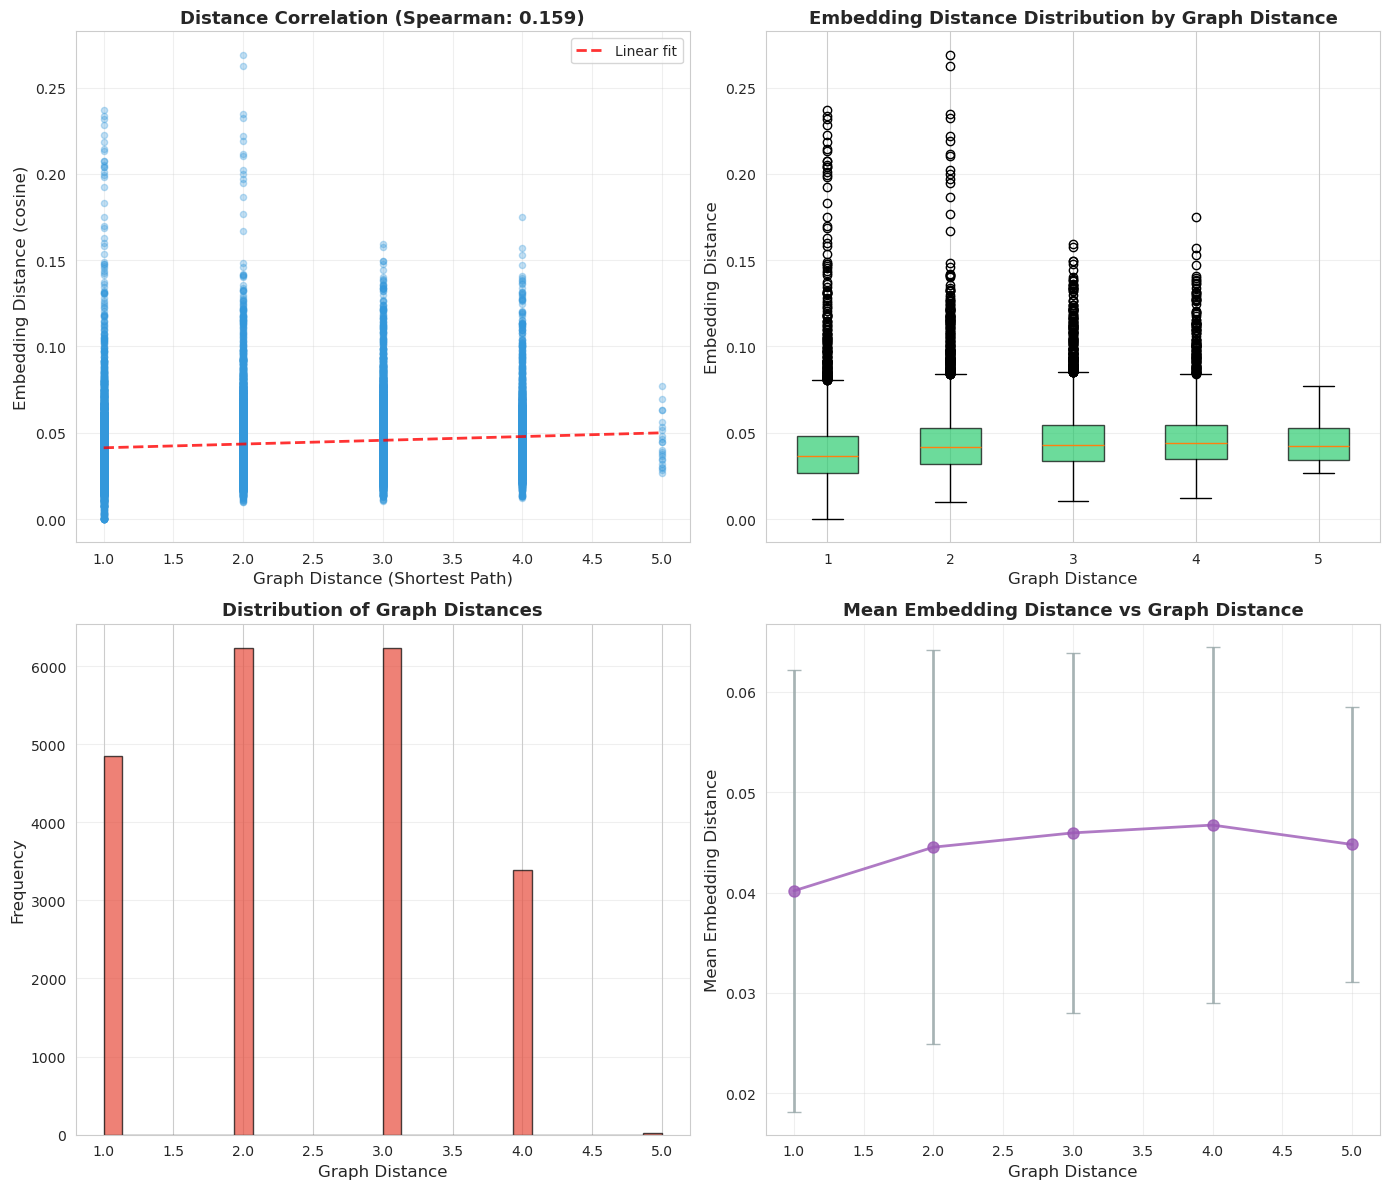

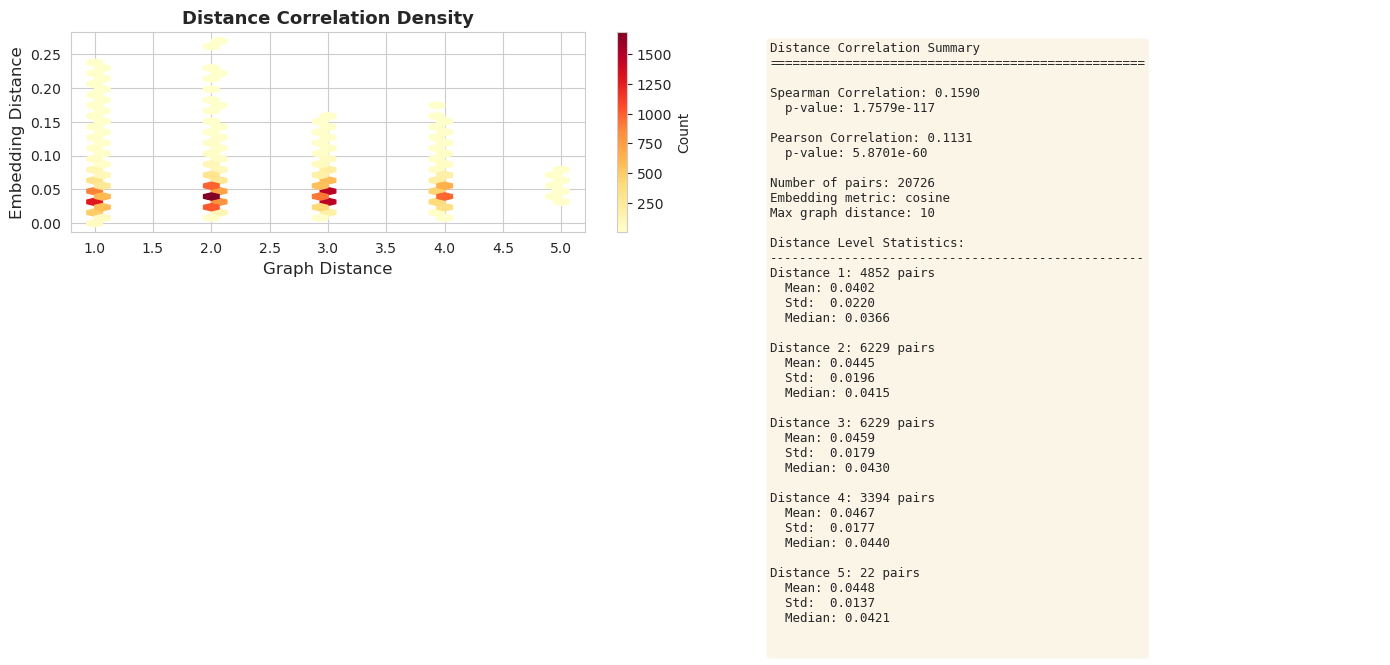

In [20]:
# Just like link_prediction.py
baseline_distance_evaluation = evaluate_distance_correlation(
    edgelist_path=edgelist_path,
    embeddings_dict=baseline_embeddings,
    test_nodes=test_val_nodes,  # List of node IDs to evaluate
    num_samples_per_node=100,     # Sample 100 pairs per test node
    max_graph_distance=10,
    embedding_distance_metric='cosine',
    sampling_strategy='stratified'  # or 'random'
)

plot_distance_correlation(baseline_distance_evaluation)

In [21]:
results_dir = BASE_DIR / "cat-hcat" / "hcat" / "experiments" / "results"

with open(results_dir / "content_results.json", 'w') as f:
    json.dump(content_results, f, default=lambda o: float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

NameError: name 'content_results' is not defined

In [22]:
with open(results_dir / "finetuned_tree_results.json", 'w') as f:
    json.dump(finetuned_tree_results, f, default=lambda o: float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

In [23]:
with open(results_dir / "baseline_tree_results.json", 'w') as f:
    json.dump(baseline_tree_results, f, default=lambda o: float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

In [24]:
with open(results_dir / "baseline_distance_results.json", 'w') as f:
    json.dump(baseline_distance_evaluation, f, 
              default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

In [25]:
with open(results_dir / "finetuned_distance_results.json", 'w') as f:
    json.dump(finetuned_distance_evaluation, f, 
              default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

In [27]:
with open(results_dir / "text_val_nodes.json", 'w') as f:
    json.dump(test_val_nodes, f, 
              default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

In [29]:
with open(results_dir / "finetuned_link_prediction_results.json", 'w') as f:
    json.dump(results, f, 
              default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

In [30]:
with open(results_dir / "baseline_link_prediction_results.json", 'w') as f:
    json.dump(baseline_results, f, 
              default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)